# Projet P6 - Classifiez automatiquement des biens de consommation
*OPENCLASSROOMS - Parcours Data Scientist - Adeline Le Ray - 05/2024*
<hr>

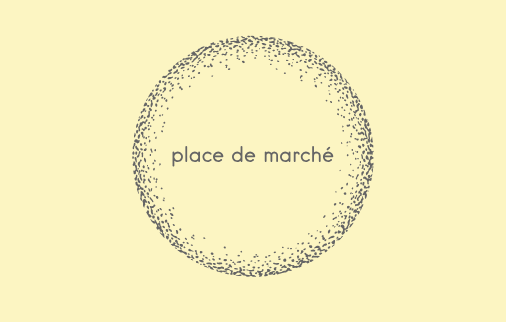

## <font color='#46abe6'>Contexte</font>

Place de marché est un site de e-commerce où des vendeurs proposent des articles à des acheteurs en postant une photo et une description.
 
ACtuellement, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.
 
Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle,  il devient nécessaire d'automatiser cette tâche d‘attribution de la catégorie.
 
L'objectif de ce projet est d'étudier la faisablité d'un moteur de classification à partir de la description textuelle ou de l'image du produit.

Cette première partie a pour but l'analyse exploratoire des données textuelles.


## <font color='#46abe6'>Sommaire</font>

<span style='background:#d5155b'><span style='color:white'>**Partie 1 - Données textuelles - Analyse exploratoire des données**</span></span>

[Importation des librairies et définition des fonctions](#1)
* [Importation des librairies](#1_1)
* [Définition des fonctions](#1_2)

[Analyse exploratoire des données](#2)
* [Importation et inspection des données](#2_1)
* [Filtres sur les variables et ajout de variables](#2_2)
* [Analyse des tokens 'description'](#2_3)
* [Analyse des tokens 'product_name'](#2_4)
* [Analyse des tokens par catégorie](#2_5)
* [Analyse des topics - Latent dirichlet allocation](#2_6)

[Conclusion & Perspectives](#3)

<span style='background:#46abe6'><span style='color:white'>**Partie 2 - Données textuelles - Feature extraction et faisabilité**</span></span>

<span style='background:#46abe6'><span style='color:white'>**Partie 3 - Images - Analyse exploratoire des données**</span></span>

<span style='background:#46abe6'><span style='color:white'>**Partie 4 - Images - Feature extraction et faisabilité**</span></span>

<span style='background:#46abe6'><span style='color:white'>**Partie 5 - Images - Classification**</span></span>

<span style='background:#46abe6'><span style='color:white'>**Partie 6 - Images - Requête API**</span></span>

# <font color='#0a389f'>Importation librairies + fonctions<a class="anchor" id="1"></a></font>

## <font color='#46abe6'>Importation des librairies<a class="anchor" id="1_1"></a></font>

In [1]:
import numpy as np
import pandas as pd

# graphiques
import matplotlib.pyplot as plt
import seaborn as sns

# inspection des dataframes
from skimpy import skim 

# Nuage de mots / Expressions régulières
from wordcloud import WordCloud
import re

# Natural language library
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

# LDA
import gensim
import cgi
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models

from sklearn import preprocessing

In [2]:
# Version python
!python --version
# Version des librairies utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))

Python 3.11.4
numpy - 1.24.4
pandas - 2.2.2
seaborn - 0.13.2
re - 2.2.1
nltk - 3.8.1
gensim - 4.3.0
cgi - 2.6
pyLDAvis - 3.4.0


In [3]:
# Paramètres par défauts des graphiques
sns.set_style('whitegrid')        # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes
width = 7
height = 5
plt.figure(figsize=(width, height))
meanprops = {'marker':'o', 'markeredgecolor':'black','markerfacecolor':'firebrick'}

<Figure size 700x500 with 0 Axes>

## <font color='#46abe6'>Fonctions<a class="anchor" id="1_2"></a></font>

In [4]:
# Fonction pour inspection df
def inspection(df, dfname):
    """!
    @brief Effectue une inspection approfondie du dataframe.

    Cette fonction affiche les premières lignes, les dimensions, les types de variables, les valeurs manquantes, 
    identifie les doublons, présente une description statistique du dataframe et un échantillon des modalités des
    variables qualitatives.

    @param df: Dataframe à inspecter (pandas DataFrame).
    @param dfname: Nom du dataframe (str).
    """
    
    # Options d'affichage : toutes les lignes
    pd.set_option('display.max_rows', None)
    
    print("*" * 50)
    print(f"Inspection du dataframe {dfname}")
    print("*" * 50)
    print("")
    
    # Affichage des premières lignes du dataframe
    print("Dataframe")
    print("-" * 50)
    display(df.head())
    print("")
    
    # Affichage des dimensions, types de variables et valeurs non-null, 
    # Description statistique du dataframe (moyenne, écart-type, min-max, médiane, IQR)
    print("Dimensions du dataframe, Types de variables, Description statistique du dataframe, Valeurs non-null")
    print("-" * 50)
    print(skim(df))
    print("")
          
    # Affichage des valeurs uniques par colonne
    print("Valeurs uniques par variable")
    print("-" * 50)   
    print(df.nunique())
    print("")
    
    # Identification et affichage des doublons
    print("Nombre de doublons")
    print("-" * 50)   
    print(df.duplicated().sum())
    print("")
    
    # Affichage d'un échantillon des modalités des variables qualitatives (si applicable)
    col = df.select_dtypes(include='object').columns.tolist()
    
    if len(col)>0:
        print("")
        print("Echantillon des modalités des variables qualitatives (5 modalités max)")
        print("-" * 50) 
        for c in col:
            print(f'{c} : {df[c].unique()[:5]}\n')   
            
    
    # Réinitialiser l'option pour revenir aux paramètres par défaut
    pd.reset_option('display.max_rows')


In [5]:
# Barplot
def plot_most_common_words(words, nb, title):
    """!
    @brief Crée et affiche un graphique à barres des mots les plus fréquents.

    Cette fonction prend une liste de mots et crée un graphique à barres pour les mots les plus fréquents. 
    Elle affiche également un titre spécifié.

    @param words: Liste de mots (list).
    @param nb: Nombre de mots à afficher dans le graphique (int).    
    @param title: Le titre à afficher pour le graphique (str).
    """
    # Comptage des mots
    word_counts = Counter(words)
    
    # Créer un DataFrame à partir des mots les plus fréquents
    df_most_common_words = pd.DataFrame(word_counts.most_common(nb), columns=['Word', 'Frequency'])
    
    # Créer le graphique à barres
    plt.figure(figsize=(15,5))
    sns.barplot(data=df_most_common_words, x='Word', y='Frequency')
    plt.xticks(rotation=90)
    plt.title(title)
    plt.show()

# WordCloud 
def generate_wordcloud(sentences, title='Word Cloud'):
    """!
    @brief Génère et affiche un nuage de mots à partir d'une chaîne de mots avec un titre.

    Cette fonction prend une chaîne de mots, génère un nuage de mots correspondant,
    et affiche ce nuage de mots en utilisant matplotlib, avec un titre spécifié.

    @param sentences: Une chaîne de mots à partir de laquelle générer le nuage de mots (str).
    @param title: Le titre à afficher au-dessus du nuage de mots (str, optionnel, défaut = 'Word Cloud').
    """
    # Créer un nuage de mots à partir de la chaîne de mots
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(sentences)
    
    # Afficher le nuage de mots
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [6]:
# Tokenizer
def tokenizer_fct(sentence) :
    """
    @brief Tokeniser un texte en éliminant les caractères spéciaux    
    @param sentence (string) : texte à traiter
    @return word_tokens (list) : tokens
    """
    # Initialisation du tokenizer
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    # Tokeniser et éliminer les caractères spéciaux
    word_tokens = tokenizer.tokenize(sentence)
    return word_tokens

# Initialisation de la liste des stopwords
stop_words = set(stopwords.words('english'))

# Filtrer les stop_words
def stop_word_filter_fct(list_words) :
    """
    @brief Filtrer les stop words dans une liste de tokens
    @param list_words (list) : liste de tokens à traiter
    @return filteredsw_words (list) : tokens nettoyés
    """
    # Filter les stopwords
    filteredsw_words = [word for word in list_words if word not in stop_words]    
    return filteredsw_words

# lower case et alpha
def lower_fct(list_words) :
    """
    @brief Passer en minuscule, sélectionner les tokens alphabétiques et de longueur > 2  
    @param list_words (list) : liste de tokens à traiter
    @return words_low (list) : tokens traités
    """
    # Passer en minuscule, sélectionner les tokens alphabétiques et de longueur > 2
    words_low = [word.lower() for word in list_words if word.isalpha() and len(word)>2]   
    return words_low

def get_wordnet_pos(nltk_pos_tag):
    """!
    @brief Convertit un tag POS de NLTK en un tag POS de WordNet.

    Cette fonction prend un tag de partie du discours (POS) de NLTK et le convertit en un tag
    de partie du discours (POS) compatible avec WordNet. Elle est utilisée pour le lemmatisation.

    @param nltk_pos_tag: Le tag de partie du discours de NLTK (str).

    @return Le tag de partie du discours de WordNet correspondant (wordnet.POS).
    """
    from nltk.corpus import wordnet

    # Convertit les tags POS de NLTK en tags POS de WordNet
    if nltk_pos_tag.startswith('J'):
        return wordnet.ADJ  # Adjectif
    elif nltk_pos_tag.startswith('V'):
        return wordnet.VERB  # Verbe
    elif nltk_pos_tag.startswith('N'):
        return wordnet.NOUN  # Nom
    elif nltk_pos_tag.startswith('R'):
        return wordnet.ADV  # Adverbe
    else:
        return wordnet.NOUN  # Par défaut, retourne Nom (NOUN)

# Lemmatizer (base d'un mot)
def lemmatizer_fct(list_words):
    """!
    @brief Lemmatise une liste de mots en spécifiant les tags de partie du discours.
    Cette fonction lemmatise une liste de mots en utilisant le lemmatiseur WordNet.
    Elle spécifie également les tags de partie du discours (POS) en utilisant la fonction get_wordnet_pos.

    @param list_words (list) : Liste de mots à traiter.
    @return lem_words (list) : Liste de mots lemmatisés.
    """
    lemmatizer = WordNetLemmatizer()
    lem_words = [lemmatizer.lemmatize(w, get_wordnet_pos(pos)) for w, pos in pos_tag(list_words)]
    return lem_words

# Filtrer les mots trop fréquents et non discriminants
def freq_word_filter_fct(list_words, freq_words) :
    """
    @brief Filtrer les mots trop fréquents et non discriminants
    @param list_words (list) : liste de tokens à traiter
    @return filtered_words (list) : tokens filtrés
    """
    # Tokens discriminants
    filtered_words = [word for word in list_words if word not in freq_words]
    return filtered_words

def preprocessing_description(sentence, freq_words):
    """
    @brief Pre-processings des tokens 
    
    Cette fonction permet de :
    - tokeniser un texte en élinant les caractères spéciaux
    - éliminer les stop words
    - passer en minuscule
    - sélectionner les tokens alphabétiques et de longueur > 2
    - lemmatiser les tokens
    - éliminer les tokens non discriminants à partir de la liste freq_words
    
    @param sentence (string) : texte à traiter
    @param freq_words (list) : liste des mots non discriminants
    @return words_final (list) : tokens nettoyés
    """
    word_tokens = tokenizer_fct(sentence)
    words_low = lower_fct(word_tokens)
    filteredsw_words = stop_word_filter_fct(words_low)
    lem_words = lemmatizer_fct(filteredsw_words)
    words_final = freq_word_filter_fct(lem_words, freq_words)
    
    return words_final

def preprocessing_product_name(sentence):
    """
    @brief Pre-processings des tokens 
    
    Cette fonction permet de :
    - tokeniser un texte en élinant les caractères spéciaux
    - éliminer les stop words
    - passer en minuscule
    - sélectionner les tokens alphabétiques et de longueur > 2
    - lemmatiser les tokens
    
    @param sentence (string) : texte à traiter
    @return lem_words (list) : tokens nettoyés
    """
    word_tokens = tokenizer_fct(sentence)
    words_low = lower_fct(word_tokens)    
    filteredsw_words = stop_word_filter_fct(words_low)
    lem_words = lemmatizer_fct(filteredsw_words)
    
    return lem_words

In [7]:
# Combiner les tokens pour chaque categorie
def combine_tokens_by_category(df, category_col, tokens_col):
    """!
    @brief Combine les tokens par catégorie et extrait les tokens les plus fréquents.

    Cette fonction prend un dataframe et combine les tokens pour chaque catégorie spécifiée. 
    Pour chaque catégorie, elle crée une chaîne de tokens combinés et extrait les 10 tokens les plus fréquents.

    @param df: Le dataframe contenant les données (pandas DataFrame).
    @param category_col: Le nom de la colonne des catégories (str).
    @param tokens_col: Le nom de la colonne contenant les listes de tokens (str).

    @return Un dataframe avec les colonnes pour la catégorie, les tokens combinés, 
            et les 10 tokens les plus fréquents (pandas DataFrame).
    """
 # Récupérer les catégories uniques dans la colonne category_col
    categories = df[category_col].unique()
    combined_tokens = []

    # Parcourir chaque catégorie pour combiner les tokens
    for cat in categories:
        # Combine tous les tokens pour la catégorie actuelle
        all_tokens = ' '.join([' '.join(tokens) for tokens in df.loc[df[category_col] == cat, tokens_col]])
        
        # Compter la fréquence de chaque token
        token_counts = Counter(all_tokens.split())
        
        # Récupérer les 10 tokens les plus fréquents
        most_common_tokens = ' '.join([token for token, _ in token_counts.most_common(10)])
        
        # Ajouter les résultats pour la catégorie actuelle à la liste
        combined_tokens.append((cat, all_tokens, most_common_tokens))
    
    # Créer un nouveau dataframe avec les résultats combinés
    return pd.DataFrame(combined_tokens, columns=[category_col, 'combined_tokens', 'most_common_tokens'])

# Wordcloud par catégorie
def plot_wordcloud(df, category_col, tokens_col):
    """!
    @brief Génère et affiche des nuages de mots pour chaque catégorie d'un dataframe.

    Cette fonction prend un dataframe et génère un nuage de mots pour chaque catégorie spécifiée.
    Elle affiche les nuages de mots pour visualiser les termes les plus fréquents dans chaque catégorie.

    @param df: Le dataframe contenant les données (pandas DataFrame).
    @param category_col: Le nom de la colonne des catégories (str).
    @param tokens_col: Le nom de la colonne contenant les tokens (str).
    """
    # Parcourir chaque ligne du dataframe
    for index, row in df.iterrows():
        category = row[category_col]
        tokens = row[tokens_col]
        
        # Créer un nuage de mots à partir des tokens
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tokens)
        
        # Afficher le nuage de mots
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for {category}')
        plt.axis('off')
        plt.show()

def find_unique_words_per_category(df, category_col, tokens_col, top_n=10):
    """!
    @brief Trouve les mots uniques les plus fréquents pour chaque catégorie d'un dataframe.

    Cette fonction identifie les mots qui sont uniques à chaque catégorie spécifiée et 
    sélectionne les mots les plus fréquents parmi ces mots uniques.

    @param df: Le dataframe contenant les données (pandas DataFrame).
    @param category_col: Le nom de la colonne des catégories (str).
    @param tokens_col: Le nom de la colonne contenant les tokens (str).
    @param top_n: Le nombre de mots les plus fréquents à sélectionner (int, optionnel, défaut = 10).

    @return Un dictionnaire de dataframes contenant les mots uniques les plus fréquents pour chaque catégorie.
            Les clés sont les catégories et les valeurs sont des dataframes avec les mots et leurs fréquences.
    """

    unique_top_words_per_category = {}
    
    # Parcourir chaque catégorie
    for category in df[category_col].unique():
        # Sélectionner les lignes de la catégorie donnée
        category_df = df[df[category_col] == category]
        
        # Compter les occurrences de chaque mot dans la catégorie
        word_counts = Counter()
        for tokens_list in category_df[tokens_col]:
            word_counts.update(tokens_list)
        
        # Filtrer les mots présents dans plusieurs catégories
        unique_words = {word: count for word, count in word_counts.items() if sum(word in word_counts for word_counts in df[df[category_col] != category][tokens_col]) == 0}
        
        # Sélectionner les top N mots restants
        top_words = dict(sorted(unique_words.items(), key=lambda item: item[1], reverse=True)[:top_n])
        
        # Ajouter les top mots pour cette catégorie
        unique_top_words_per_category[category] = top_words
    
    # Créer un DataFrame pour chaque catégorie
    dfs = {}
    for category, word_freqs in unique_top_words_per_category.items():
        dfs[category] = pd.DataFrame({"Word": list(word_freqs.keys()), "Frequency": list(word_freqs.values())})
    
    return dfs

# <font color='#0a389f'>Partie 1 - Analyse exploratoire et Nettoyage des données textuelles<a class="anchor" id="1"></a></font>

## <font color='#46abe6'>Importation et inspection des données<a class="anchor" id="2_1"></a></font>

In [8]:
# Importation des données
path = 'C:/Users/Adeline/OneDrive/Documents/5-Openclassrooms/Parcours DS/P6/Dataset+projet+prétraitement+textes+images/Flipkart/'
text_data_raw=pd.read_csv(path+'flipkart_com-ecommerce_sample_1050.csv', sep=',')

In [9]:
inspection(text_data_raw,'Descriptions textuelles')

**************************************************
Inspection du dataframe Descriptions textuelles
**************************************************

Dataframe
--------------------------------------------------


uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...


Dimensions du dataframe, Types de variables, Description statistique du dataframe, Valeurs non-null
--------------------------------------------------


╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 1050   │ │ string      │ 12    │                                                          │
│ │ Number of columns │ 15     │ │ float64     │ 2     │                                                          │
│ └───────────────────┴────────┘ │ bool        │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name           ┃ NA   ┃ NA %   ┃ mean   ┃ sd     ┃ p0  ┃ p25   ┃ p50    ┃ p75   ┃ p100    ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩  │
│ │ retail_price          │    1 │    0.1 │   2200 │   7600 │  35 │   560 │   1000 │  2000 │  200000 │    ▇    │  │
│ │ discounted_price      │    1 │    0.1 │   1600 │   7500 │  35 │   340 │    600 │  1200 │  200000 │    ▇    │  │
│ └───────────────────────┴──────┴────────┴────────┴────────┴─────┴───────┴────────┴───────┴─────────┴─────────┘  │
│                                                      bool                                                       │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                                      ┃ true         ┃ true rate              ┃ hist            ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩  │
│ │ is_FK_Advantage_product                          │           57 │                  0.054 │        ▇        │  │
│ └──────────────────────────────────────────────────┴──────────────┴────────────────────────┴─────────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                         ┃ NA      ┃ NA %       ┃ words per row           ┃ total words         ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ uniq_id                             │       0 │          0 │                       1 │                1050 │  │
│ │ crawl_timestamp                     │       0 │          0 │                       3 │                3150 │  │
│ │ product_url                         │       0 │          0 │                       1 │                1050 │  │
│ │ product_name                        │       0 │          0 │                     7.6 │                7998 │  │
│ │ product_category_tree               │       0 │          0 │                      15 │               15659 │  │
│ │ pid                                 │       0 │          0 │                       1 │                1050 │  │
│ │ image                               │       0 │          0 │                       1 │                1050 │  │
│ │ description                         │       0 │          0 │                      80 │               84338 │  │
│ │ product_rating                      │       0 │     

None

Valeurs uniques par variable
--------------------------------------------------
uniq_id                    1050
crawl_timestamp             149
product_url                1050
product_name               1050
product_category_tree       642
pid                        1050
retail_price                354
discounted_price            424
image                      1050
is_FK_Advantage_product       2
description                1050
product_rating               27
overall_rating               27
brand                       490
product_specifications      984
dtype: int64

Nombre de doublons
--------------------------------------------------
0


Echantillon des modalités des variables qualitatives (5 modalités max)
--------------------------------------------------
uniq_id : ['55b85ea15a1536d46b7190ad6fff8ce7' '7b72c92c2f6c40268628ec5f14c6d590'
 '64d5d4a258243731dc7bbb1eef49ad74' 'd4684dcdc759dd9cdf41504698d737d8'
 '6325b6870c54cd47be6ebfbffa620ec7']

crawl_timestamp : ['2016-04-30 03:

* Primary key : `uniq_id`
* Classification : `product_category_tree`, nb : 642
* Lien avec l'image : `image`
* Informations vendeurs sur le produit : `description` et `product_name`

## <font color='#46abe6'>Filtres sur les variables et ajout de variables catégories<a class="anchor" id="2_2"></a></font>

Variables retenues pour l'étude de faisabilité : 
* 'uniq_id', 
* 'product_name',
* 'product_category_tree', 
* 'description'

In [10]:
# Distribution des longueurs des catégories
text_data_raw['product_category_tree'].apply(lambda x: len(x.strip('[]').split('>>'))).value_counts()

product_category_tree
3    368
5    278
4    274
6     70
7     57
2      3
Name: count, dtype: int64

Tous les produits n'ont pas le même nombre de catégories et sous-catégories : Nous conserverons les 2 premières dans une premier temps.

In [11]:
# Ajout de la colonne 'len_description' initialisée à zéro
text_data_raw['len_description'] = 0
text_data_raw['len_product_name'] = 0

# Ajout des colonnes 'main_category' et 'sub_category' initialisées à None
text_data_raw['main_category'] = None
text_data_raw['sub_category'] = None

for i in range(len(text_data_raw)):
    # Longueur des descriptions
    text_data_raw.loc[i, 'len_description'] = len(text_data_raw.loc[i, 'description'])
    # Longueur des product_name
    text_data_raw.loc[i, 'len_product_name'] = len(text_data_raw.loc[i, 'product_name'])
    
    # main_category + sub_category
    categories = text_data_raw.loc[i, 'product_category_tree'].strip('[" "]').split(' >> ')
    text_data_raw.loc[i,'main_category'] = categories[0]
    text_data_raw.loc[i, 'sub_category'] = categories[1] if len(categories) > 1 else None

    # Filtre sur les variables
text_data = text_data_raw[['uniq_id', 
                           'product_name', 
                           'main_category', 
                           'sub_category', 
                           'description', 
                           'len_description', 
                           'len_product_name']]

In [12]:
# Nombre de produits par main_categorie
text_data.main_category.value_counts().reset_index()

main_category  count
0             Home Furnishing    150
1                   Baby Care    150
2                     Watches    150
3  Home Decor & Festive Needs    150
4            Kitchen & Dining    150
5    Beauty and Personal Care    150
6                   Computers    150

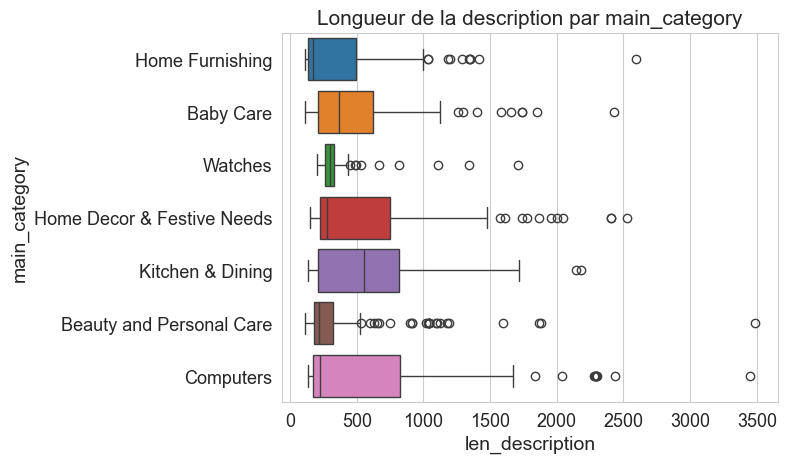

In [13]:
# Longueur de la description par main_category
sns.boxplot(data=text_data, x='len_description', y='main_category', hue='main_category')
plt.title('Longueur de la description par main_category')
plt.show()

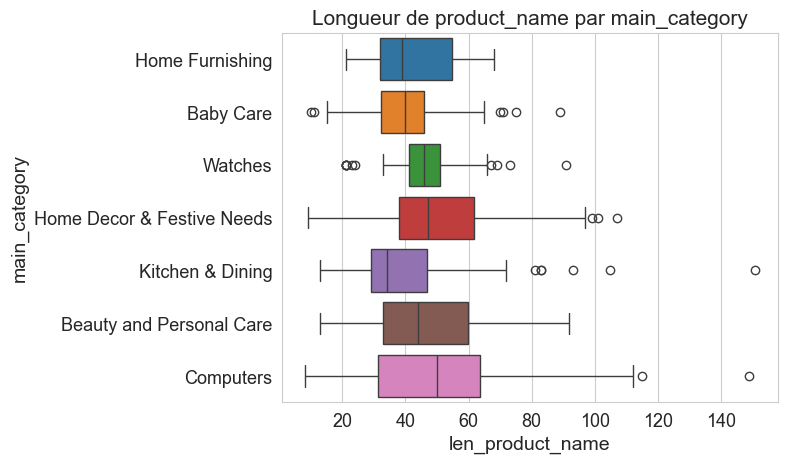

In [14]:
# Longueur de product_name par main_category
sns.boxplot(data=text_data, x='len_product_name', y='main_category', hue='main_category')
plt.title('Longueur de product_name par main_category')
plt.show()

## <font color='#46abe6'>Analyse des tokens 'description'<a class="anchor" id="2_3"></a></font>

Recherchons les tokens présents dans les descriptions et leurs occurences.

In [15]:
# Concaténation de toutes les descriptions en une seule chaîne de caractères
all_descriptions = ' '.join(text_data['description'])

In [16]:
# Exemple
all_descriptions[:300]

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabr'

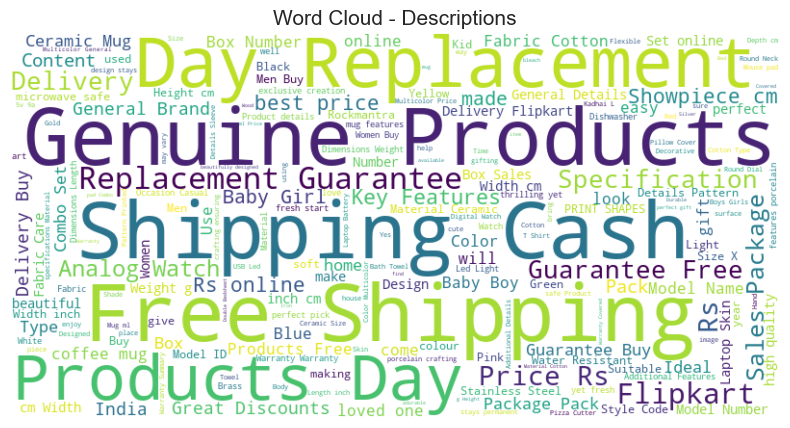

In [17]:
# Création d'un objet WordCloud
generate_wordcloud(all_descriptions, title='Word Cloud - Descriptions')

In [18]:
# Tokeniser les descriptions
all_words = nltk.word_tokenize(all_descriptions)

# Fréquence de chaque token
all_words_counts = Counter(all_words)

# Création du DataFrame 
word_count = pd.DataFrame(all_words_counts.most_common(20), columns=['Token', 'Count'])
display(word_count.sort_values('Count', ascending=False).head(20))

Token  Count
0          .   4255
1          ,   3133
2         of   1659
3        and   1167
4        the   1015
5          :   1007
6         to    982
7          -    930
8        for    825
9         in    753
10      Only    717
11        at    701
12      with    688
13         )    682
14         (    669
15         !    606
16       For    604
17      your    600
18        Rs    592
19  Products    577

* Les tokens les plus fréquents sont des stop words et des caractères spéciaux.
* Nous observons aussi des mots de 2 lettres (X, cm, Rs, ...), des majuscules / minuscules.
* Dans les mots les plus fréquents, il y a des mots qui ne nous apportent pas d'informations sur la catégorie du produit : 'Products', 'Free', 'Shipping', 'Guarantee', 'Flipkart', 'Genuine', 'Replacement', ... Nous pouvons voir aussi qu'il y a des différences de casses et des mots qui reviennent plusieurs fois comme Products et Shipping.

### Caractères spéciaux

* L'inspection des descriptions a montré qu'il manquait parfois des espaces derrière certains caractères spéciaux : '.', ','. Nous allons utilisé nltk.RegexpTokenizer(r'[^\w\s]') pour détecter toute la ponctuation.

In [19]:
# Utilisation d'une expression régulière pour rechercher des caractères spéciaux
tokenizer = nltk.RegexpTokenizer(r'[^\w\s]')
special_characters = tokenizer.tokenize(all_descriptions)

# Fréquence de chaque caractère spécial
special_character_freq = Counter(special_characters)

# Création du DataFrame 
special_character_count = pd.DataFrame(special_character_freq.items(), columns=['Special_character', 'Count'])
display(special_character_count.sort_values('Count', ascending=False))

Special_character  Count
4                  .   5885
0                  ,   3269
6                  -   1738
3                  :   1029
2                  )    682
1                  (    669
10                 !    606
7                  &    513
11                 '    396
9                  /    280
13                 "    227
27                 #    144
5                  %     81
12                 *     51
15                 +     32
23                 •     29
22                 ;     24
19                 |     18
20                 ’     16
21                 ?     12
18                 �     11
16                 @      9
17                 …      5
14                 °      4
24                 [      2
25                 ]      2
26                 –      2
29                 “      2
30                 ”      2
8                  ±      1
28                 `      1

In [20]:
# Utilisation d'une expression régulière pour rechercher uniquement les mots
tokenizer = nltk.RegexpTokenizer(r'\w+')

In [21]:
# Exemple test
test = text_data['description'].iloc[0]
test_words = tokenizer.tokenize(test)
display(test_words[:40])

['Key',
 'Features',
 'of',
 'Elegance',
 'Polyester',
 'Multicolor',
 'Abstract',
 'Eyelet',
 'Door',
 'Curtain',
 'Floral',
 'Curtain',
 'Elegance',
 'Polyester',
 'Multicolor',
 'Abstract',
 'Eyelet',
 'Door',
 'Curtain',
 '213',
 'cm',
 'in',
 'Height',
 'Pack',
 'of',
 '2',
 'Price',
 'Rs',
 '899',
 'This',
 'curtain',
 'enhances',
 'the',
 'look',
 'of',
 'the',
 'interiors',
 'This',
 'curtain',
 'is']

In [22]:
# Tokenisation des descriptions
words = tokenizer.tokenize(all_descriptions)

### Majuscule / minuscules, uniquement alphabétique

L'objectif ici est de mettre les mots en minuscules, conserver uniquement les mots (éliminer les chiffres) et éliminer les mots de moins de 2 lettres.

In [23]:
# Exemple test 
test_words_low = [word.lower() for word in test_words if word.isalpha() and len(word)>2]
display(test_words_low[:30])

['key',
 'features',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'floral',
 'curtain',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'height',
 'pack',
 'price',
 'this',
 'curtain',
 'enhances',
 'the',
 'look',
 'the',
 'interiors',
 'this',
 'curtain']

In [24]:
# Passage en minuscule
words_low = [word.lower() for word in words if word.isalpha() and len(word)>2]

### Stop words

In [25]:
# Fréquence de chaque caractère spécial
words_freq = Counter(words_low)

# Création du DataFrame 
words_count = pd.DataFrame(words_freq.items(), columns=['Word', 'Count'])
display(words_count.sort_values('Count', ascending=False).head(20))

Word  Count
99           for   1436
15           the   1369
32           and   1332
226         only    890
25          with    843
42          your    656
149     products    631
251         free    618
240          buy    581
254     delivery    567
252     shipping    564
253         cash    564
247      genuine    564
249  replacement    559
248          day    540
243     flipkart    481
244          com    473
250    guarantee    471
13          this    444
241       online    396

Nous observons beaucoup de stop words dans les tokens les plus fréquents.

In [26]:
# Récupération des stop words de NLTK
stop_words = set(stopwords.words('english'))

In [27]:
# Exemple test 
test_words_cleaned = [word for word in test_words_low if word not in stop_words]
display(test_words_cleaned[:25])

['key',
 'features',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'floral',
 'curtain',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'height',
 'pack',
 'price',
 'curtain',
 'enhances',
 'look',
 'interiors']

In [28]:
# Suppression des stop words de NLTK
words_cleaned = [word for word in words_low if word not in stop_words]

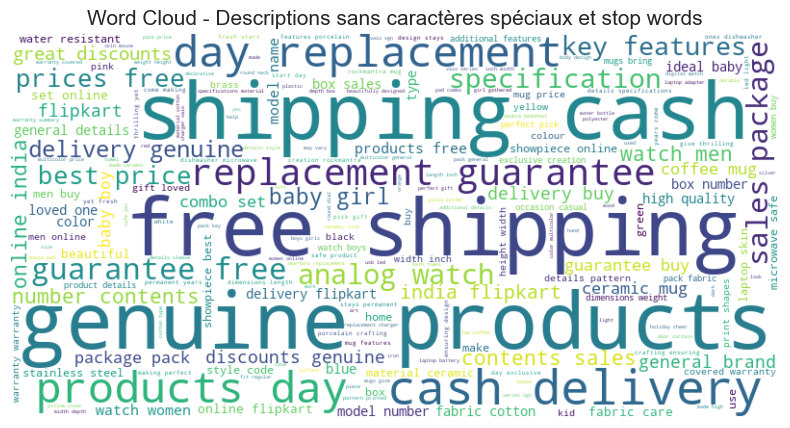

In [29]:
# Création d'un objet WordCloud
words_joined = ' '.join(words_cleaned)

generate_wordcloud(words_joined, title='Word Cloud - Descriptions sans caractères spéciaux et stop words')

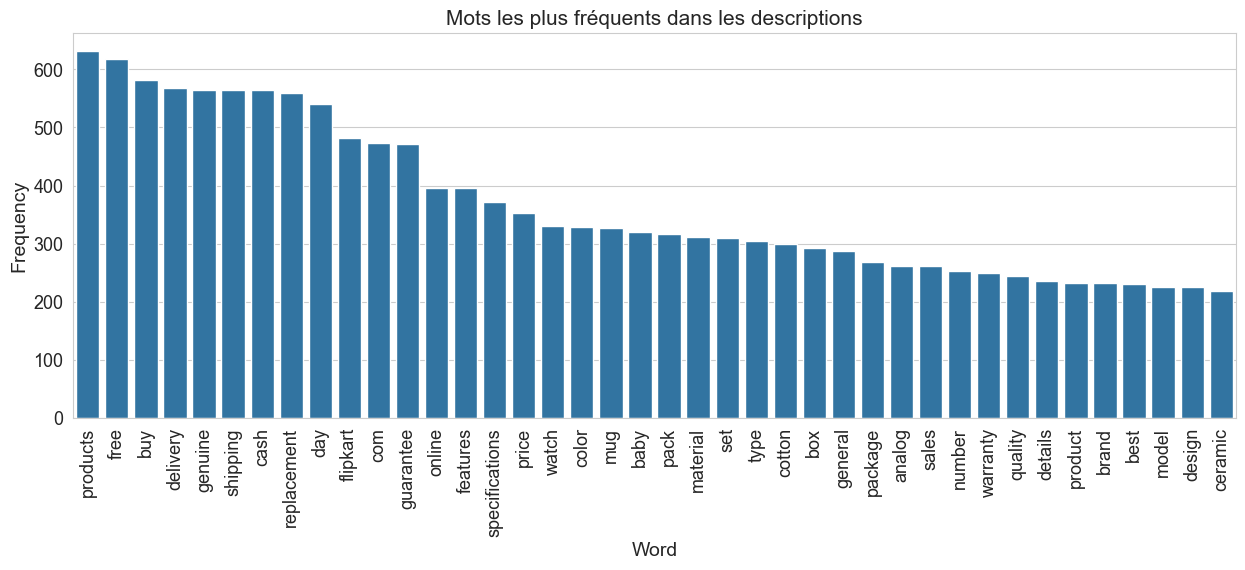

In [30]:
# Affichage des mots les plus fréquents
plot_most_common_words(words_cleaned, 40, 'Mots les plus fréquents dans les descriptions')

Les mots les plus fréquents ne nous apportent pas d'informations sur la catégorie du produit. On peut voir aussi le même mot apparaître au singulier et au pluriel. Avant d'écarter les mots les plus fréquents, nous allons lemmatiser les mots pour les avoir sous leur forme canonique. ou les raciniser.

### Lemmatisation ou racinisation (stemming)

* **Lemmatisation**

In [31]:
# Initialisation du Lemmatizer
lemmatizer = WordNetLemmatizer()

In [32]:
# Exemple test 
test_pos_tags = pos_tag(test_words_cleaned)
test_words_lem = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in test_pos_tags]
display(test_words_lem[:25])

['key',
 'feature',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'floral',
 'curtain',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'height',
 'pack',
 'price',
 'curtain',
 'enhances',
 'look',
 'interior']

In [33]:
# Lemmatiser les tokens
pos_tags = pos_tag(words_cleaned)
lem_words = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]

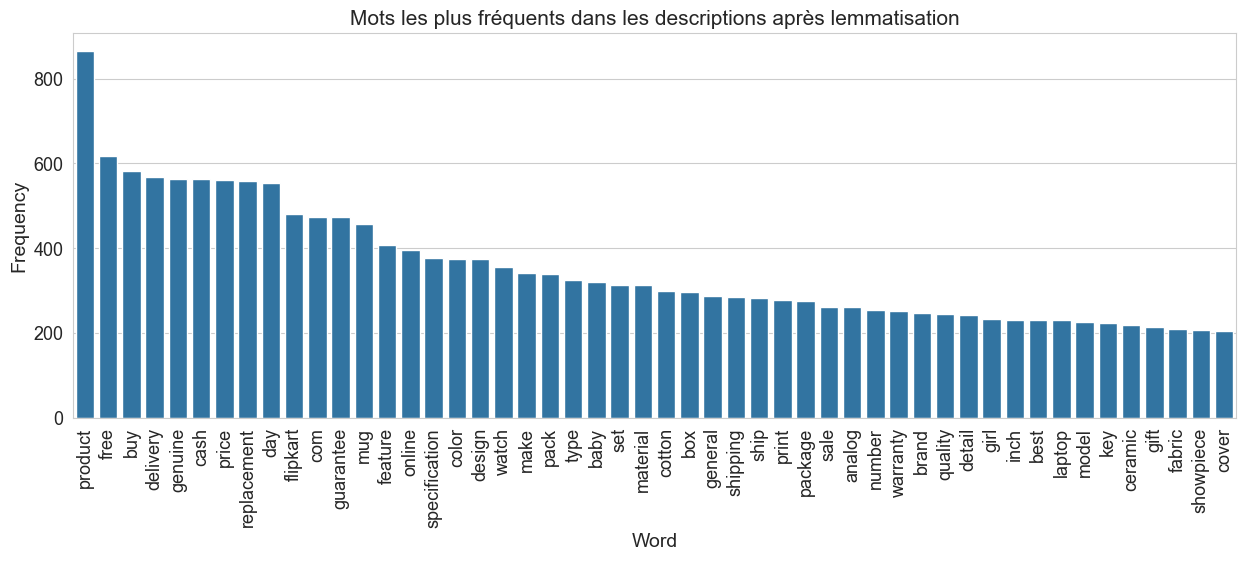

In [34]:
# Affichage des mots les plus fréquents
plot_most_common_words(lem_words, 50, 'Mots les plus fréquents dans les descriptions après lemmatisation')

* **Racinisation (Stemming)**

In [35]:
# Initialisation du Stemmer
stemmer = SnowballStemmer("english")

In [36]:
# Exemple test 
test_words_stem = [stemmer.stem(word) for word in test_words_cleaned]
display(test_words_stem[:25])

['key',
 'featur',
 'eleg',
 'polyest',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'floral',
 'curtain',
 'eleg',
 'polyest',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'height',
 'pack',
 'price',
 'curtain',
 'enhanc',
 'look',
 'interior']

In [37]:
# Stemming
stem_words = [stemmer.stem(word) for word in words_cleaned]

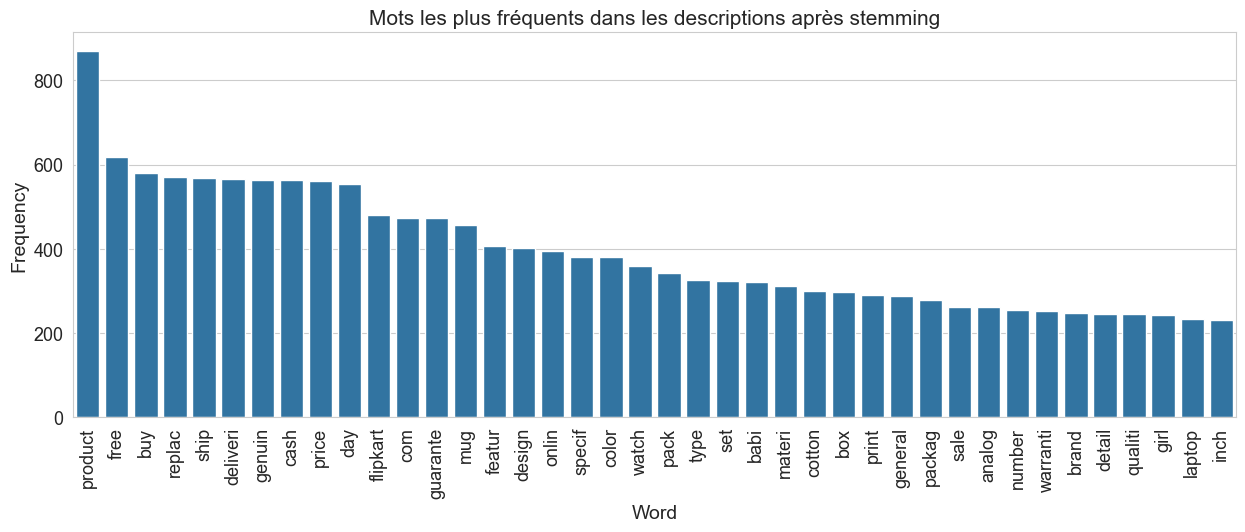

In [38]:
# Affichage des mots les plus fréquents
plot_most_common_words(stem_words, 40, 'Mots les plus fréquents dans les descriptions après stemming')

La lemmatisation a eu des résultats plus concluants et exploitables: nous conserverons plutôt cette méthode pour la suite.

### Mots trop fréquents et non discriminants

Nous observons dans les premiers mots les plus fréquents des mots non discriminants pour la classification. Ces mots sont à éliminer pour les modèles puissent réaliser une classification pertinente.

In [39]:
except_list = ['mug', 'watch', 'baby', 'cotton', 'analog', 'girl', 'laptop', 'ceramic', 'boy','men', 'skin', 'usb','home']

In [40]:
# Liste des mots les plus fréquents
df_most_common = pd.DataFrame(Counter(lem_words).most_common(50), columns=['Word', 'Frequency'])
most_freq  = [word for word in df_most_common['Word'] if word not in except_list]

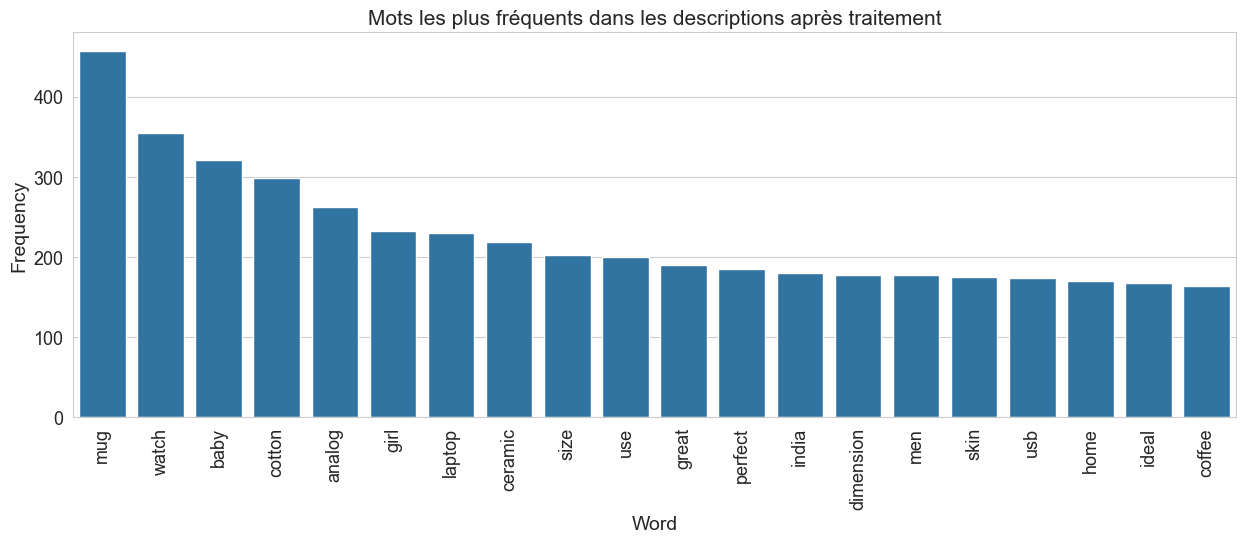

In [41]:
# Suppression des mots les plus fréquents
freq_words = set(most_freq)
words_final = [word for word in lem_words if word not in freq_words]

# Affichage des mots les plus fréquents
plot_most_common_words(words_final, 20, 'Mots les plus fréquents dans les descriptions après traitement')

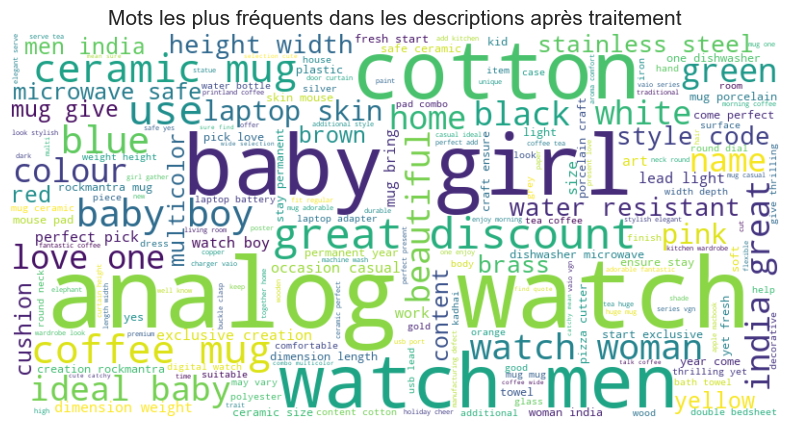

In [42]:
# Création d'un objet WordCloud
words_final_joined = ' '.join(words_final)

generate_wordcloud(words_final_joined, title='Mots les plus fréquents dans les descriptions après traitement')

## <font color='#46abe6'>Analyse des tokens 'product_name'<a class="anchor" id="2_4"></a></font>

Recherchons les tokens présents dans les products_names et leurs occurences.

In [43]:
# Concaténation de toutes les product_name en une seule chaîne de caractères
all_names = ' '.join(text_data['product_name'])

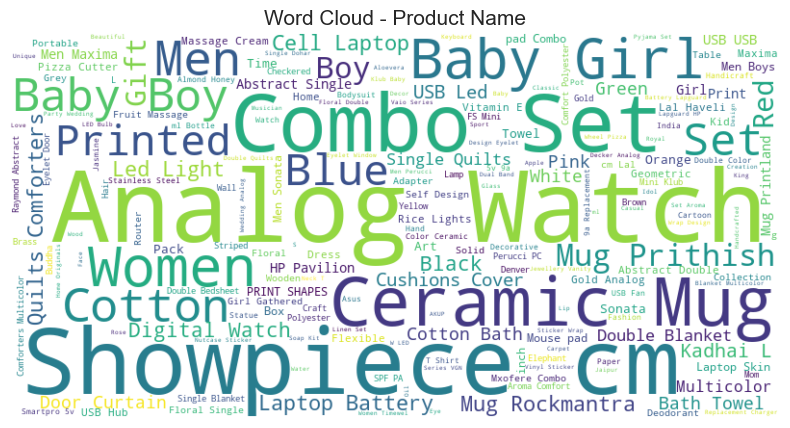

In [44]:
# Création d'un objet WordCloud
generate_wordcloud(all_names, title='Word Cloud - Product Name')

In [45]:
# Tokeniser les descriptions
all_words = nltk.word_tokenize(all_names)

# Fréquence de chaque token
all_words_counts = Counter(all_words)

# Création du DataFrame 
word_count = pd.DataFrame(all_words_counts.most_common(20), columns=['Token', 'Count'])
display(word_count.sort_values('Count', ascending=False).head(20))

Token  Count
0           -    286
1         For    156
2       Watch    150
3         Set    129
4      Analog    127
5           ,    111
6          cm    109
7   Showpiece    104
8        Baby     92
9       Combo     90
10         's     88
11        Men     78
12    Ceramic     78
13        Mug     76
14          &     75
15        USB     60
16      Women     55
17     Cotton     54
18       Girl     52
19     Single     45

* Il y a ici aussi des stop words et des caractères spéciaux.

### Caractères spéciaux

In [46]:
# Utilisation d'une expression régulière pour rechercher des caractères spéciaux
tokenizer = nltk.RegexpTokenizer(r'[^\w\s]')
special_characters = tokenizer.tokenize(all_names)

# Fréquence de chaque caractère spécial
special_character_freq = Counter(special_characters)

# Création du DataFrame 
special_character_count = pd.DataFrame(special_character_freq.items(), columns=['Special_character', 'Count'])
display(special_character_count.sort_values('Count', ascending=False))

Special_character  Count
0                  -    505
1                  ,    119
2                  .    104
3                  '     99
4                  &     75
5                  (     26
6                  )     26
9                  /     22
13                 +     21
12                 "      4
8                  �      3
14                 !      3
7                  @      2
11                 ?      2
10                 :      1
15                 %      1

### Majuscule / minuscules, uniquement alphabétique

L'objectif ici est de mettre les mots en minuscules, conserver uniquement les mots (éliminer les chiffres) et éliminer les mots de moins de 2 lettres.

In [47]:
# Utilisation d'une expression régulière pour rechercher uniquement les mots
tokenizer = nltk.RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(all_names)

In [48]:
# Passage en minuscule
words_low = [word.lower() for word in words if word.isalpha() and len(word)>2]

### Stop words

In [49]:
# Fréquence de chaque caractère spécial
words_freq = Counter(words_low)

# Création du DataFrame 
words_count = pd.DataFrame(words_freq.items(), columns=['Word', 'Count'])
display(words_count.sort_values('Count', ascending=False).head(20))

Word  Count
30         for    169
29       watch    150
14         set    135
28      analog    131
265  showpiece    105
121       baby     94
190      combo     93
101    ceramic     78
33         men     78
140        mug     76
159        usb     60
8       cotton     55
52       women     55
122       girl     52
164       with     47
343     single     45
119        and     42
21      double     40
949     laptop     38
3     abstract     37

Nous observons des stop words dans les tokens les plus fréquents.

In [50]:
# Suppression des stop words de NLTK
stop_words = set(stopwords.words('english'))
words_cleaned = [word for word in words_low if word not in stop_words]

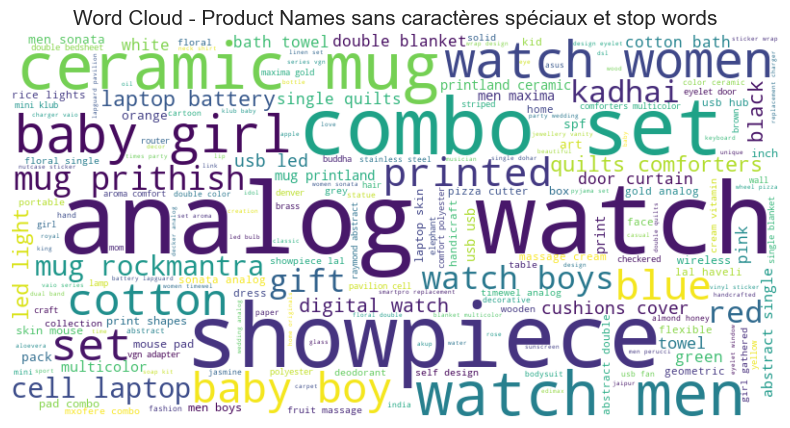

In [51]:
# Création d'un objet WordCloud
words_joined = ' '.join(words_cleaned)

generate_wordcloud(words_joined, title='Word Cloud - Product Names sans caractères spéciaux et stop words')

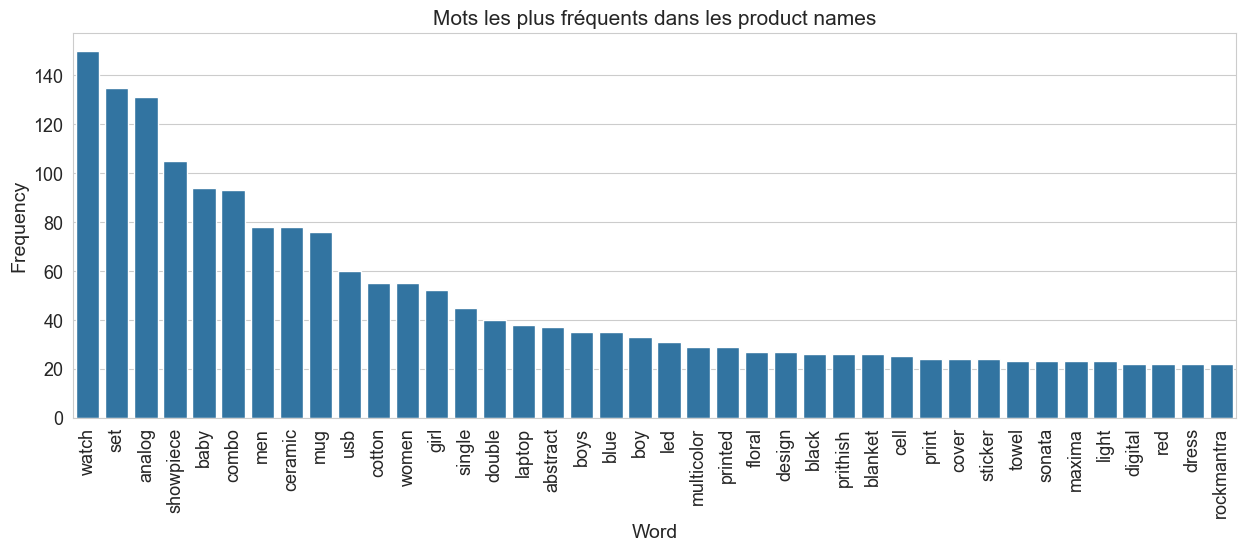

In [52]:
# Affichage des mots les plus fréquents
plot_most_common_words(words_cleaned, 40, 'Mots les plus fréquents dans les product names')

Nous pouvons voir le même mot apparaître au singulier et au pluriel : 'boys' et 'boy'. Nous allons lemmatiser les mots pour les avoir sous leur forme canonique. ou les raciniser.

### Lemmatisation ou racinisation (stemming)

* **Lemmatisation**

In [53]:
# Lemmatiser les tokens
lemmatizer = WordNetLemmatizer()
lem_words = [lemmatizer.lemmatize(word) for word in words_cleaned]

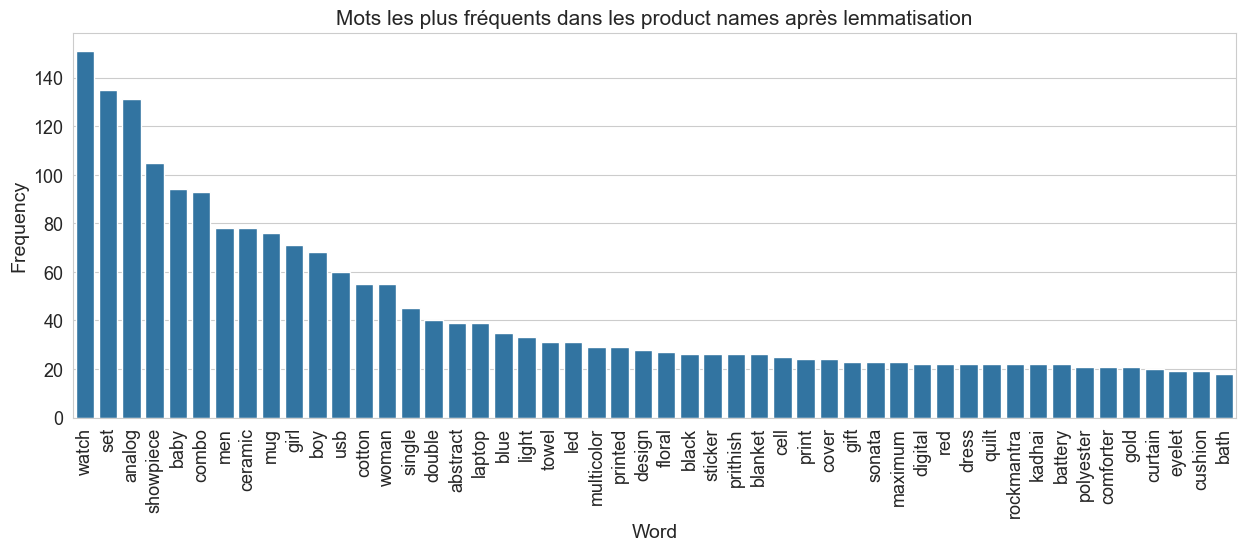

In [54]:
# Affichage des mots les plus fréquents
plot_most_common_words(lem_words, 50, 'Mots les plus fréquents dans les product names après lemmatisation')

* **Racinisation (Stemming)**

In [55]:
# Stemming
stemmer = SnowballStemmer("english")
stem_words = [stemmer.stem(word) for word in words_cleaned]

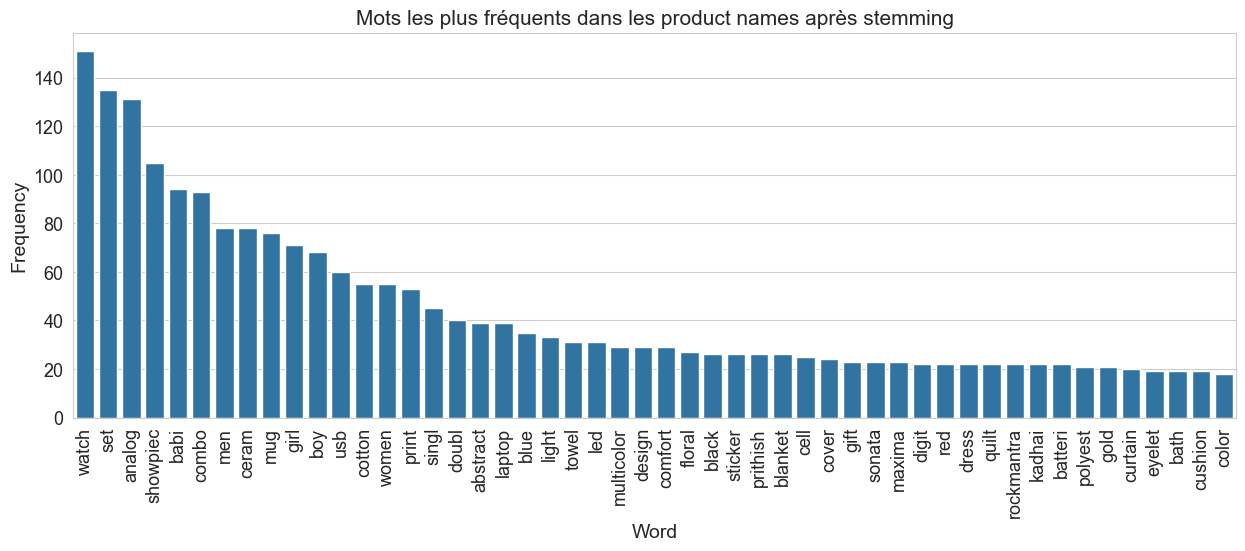

In [56]:
# Affichage des mots les plus fréquents
plot_most_common_words(stem_words, 50, 'Mots les plus fréquents dans les product names après stemming')

La lemmatisation a eu des résultats plus concluants et exploitables: nous conserverons plutôt cette méthode pour la suite.

## <font color='#46abe6'>Analyse des tokens par catégories<a class="anchor" id="2_5"></a></font>

In [57]:
# Pre-processing des colonnes 'description' et 'product_name'
df_tokens = text_data.copy()
df_tokens.loc[:, 'tokens_desc'] = text_data['description'].apply(lambda x: preprocessing_description(x, freq_words))
df_tokens.loc[:, 'tokens_name'] = text_data['product_name'].apply(lambda x: preprocessing_product_name(x))

In [58]:
# Nombres de tokens
for i in range(len(df_tokens)):
    # Longueur des descriptions
    df_tokens.loc[i, 'len_tokens_desc'] = len(df_tokens.loc[i, 'tokens_desc'])
    # Longueur des product_name
    df_tokens.loc[i, 'len_tokens_name'] = len(df_tokens.loc[i, 'product_name'])

In [59]:
df_tokens[['len_tokens_desc', 'len_tokens_name']].describe()

len_tokens_desc  len_tokens_name
count      1050.000000      1050.000000
mean         35.796190        45.101905
std          41.935426        17.497326
min           1.000000         8.000000
25%           7.000000        33.000000
50%          19.000000        43.000000
75%          52.750000        55.000000
max         317.000000       151.000000

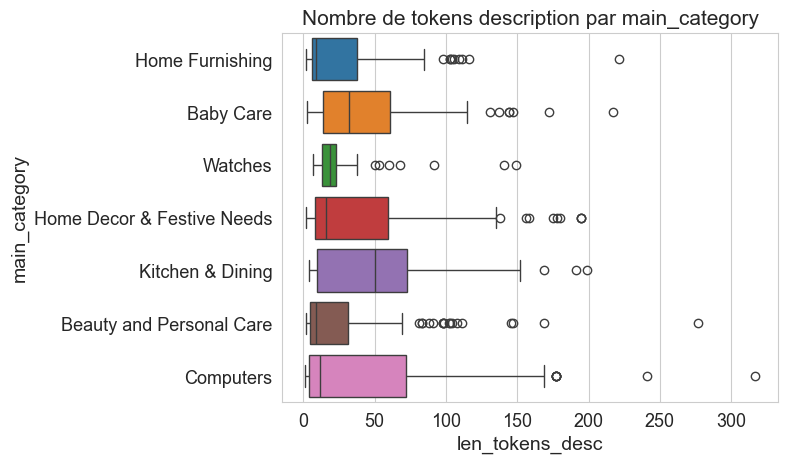

In [60]:
# Nombre de tokens_desc par main_category
sns.boxplot(data=df_tokens, x='len_tokens_desc', y='main_category', hue='main_category')
plt.title('Nombre de tokens description par main_category')
plt.show()

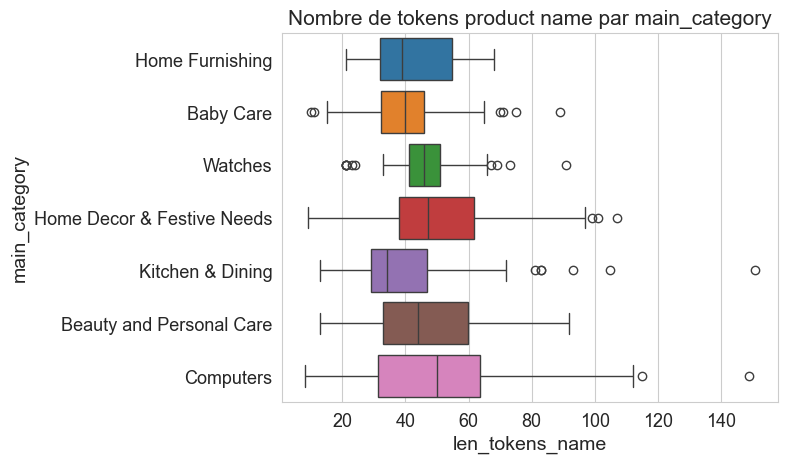

In [61]:
# Nombre de tokens_name par main_category
sns.boxplot(data=df_tokens, x='len_tokens_name', y='main_category', hue='main_category')
plt.title('Nombre de tokens product name par main_category')
plt.show()

In [62]:
# Dataframe avec les tokens fusionnés pour chaque categorie
df_combined_tokens = combine_tokens_by_category(df_tokens, 'main_category', 'tokens_desc')

pd.set_option('display.max_colwidth', None)
display(df_combined_tokens[['main_category', 'most_common_tokens']])
pd.reset_option('display.max_colwidth')

main_category  \
0             Home Furnishing   
1                   Baby Care   
2                     Watches   
3  Home Decor & Festive Needs   
4            Kitchen & Dining   
5    Beauty and Personal Care   
6                   Computers   

                                                              most_common_tokens  
0  cotton towel cushion polyester single multicolor curtain width blanket floral  
1                      baby girl cotton dress boy ideal sleeve neck wash pattern  
2               watch analog men india great discount woman dial strap resistant  
3                 wall home brass dimension art beautiful light room width paper  
4                  mug ceramic coffee perfect love one safe give rockmantra come  
5                      combo skin hair soap oil trait body jewellery ideal cream  
6                  laptop usb adapter power battery skin light charger high vaio

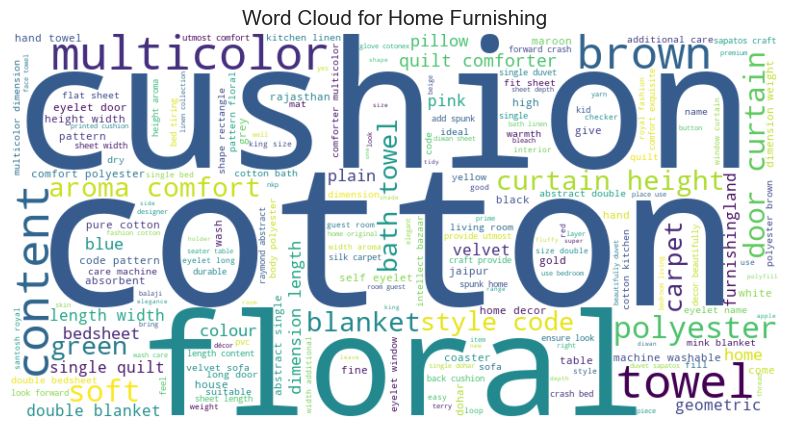

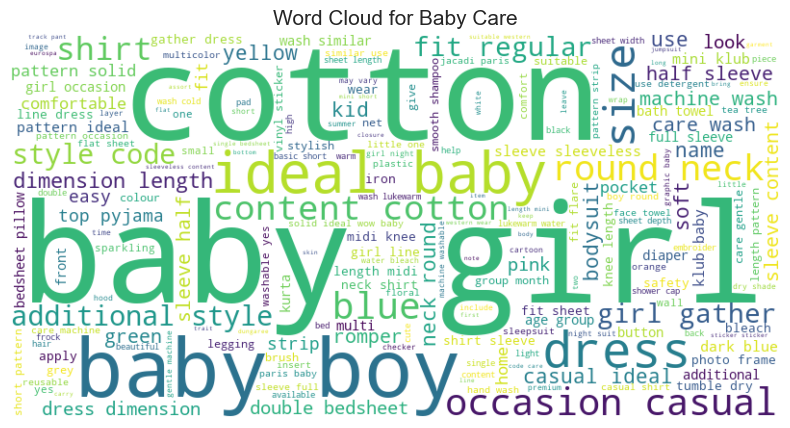

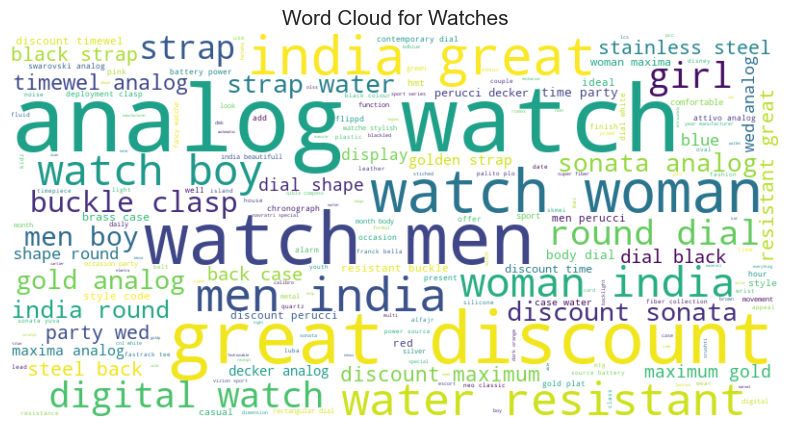

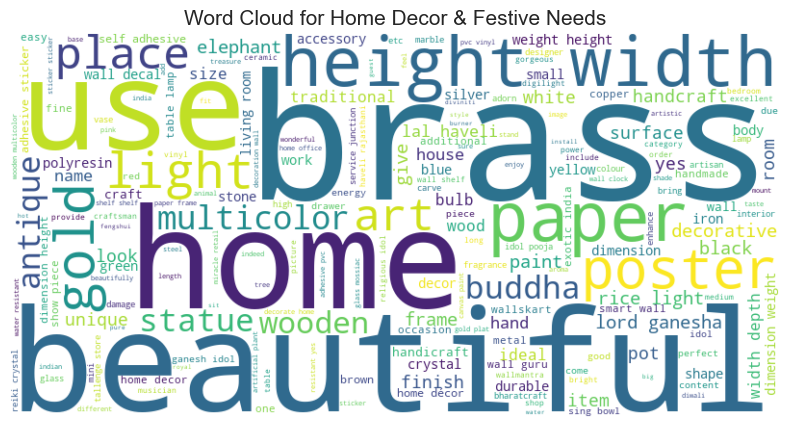

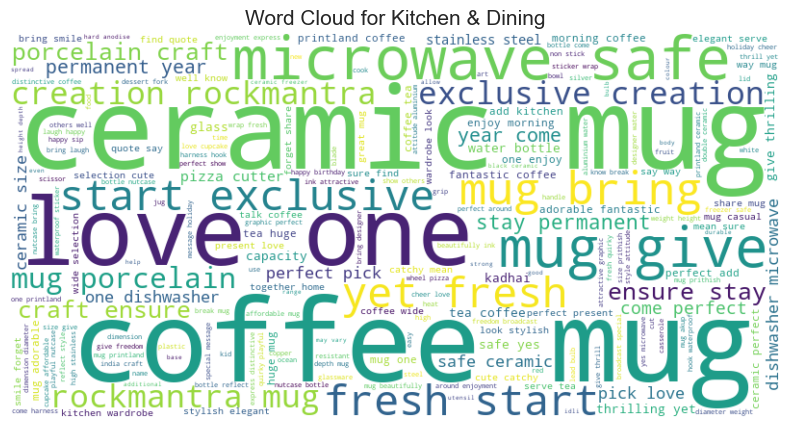

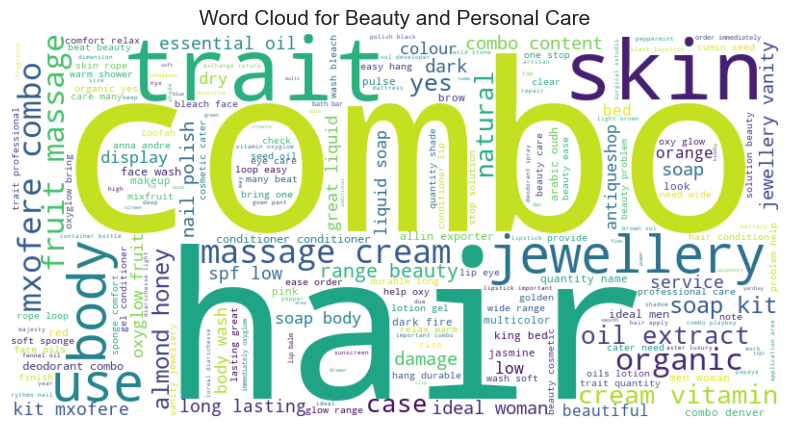

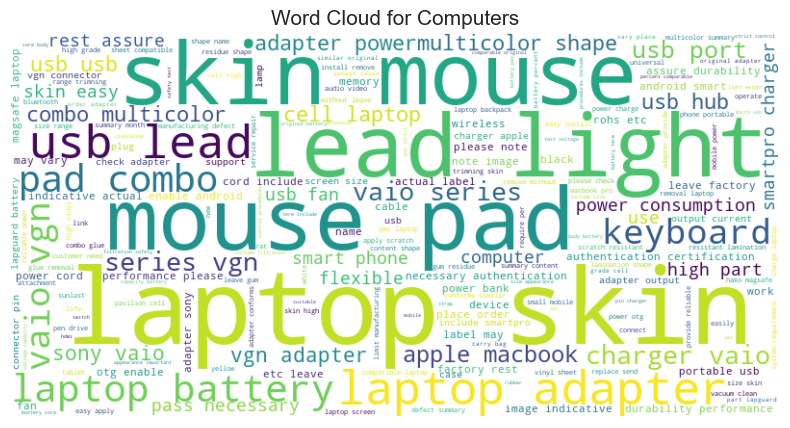

In [63]:
# Nuages de mots par catégorie
plot_wordcloud(df_combined_tokens, 'main_category', 'combined_tokens')

Nous retrouvons des mots en communs dans plusieurs catégories. Exemple : 'skin' dans Beauty and Personal Care et dans Caomputers.

In [64]:
# Top 10 des mots uniques par catégorie
unique_top_words_per_category = find_unique_words_per_category(df_tokens, 'main_category', 'tokens_desc')

# Affichage des DataFrames par catégorie
for category, df in unique_top_words_per_category.items():
    print(f"Category: {category}")
    display(df)

Category: Home Furnishing


Word  Frequency
0         curtain         53
1           quilt         45
2          eyelet         44
3          carpet         37
4       comforter         31
5           duvet         23
6         cotonex         16
7  furnishingland         15
8           diwan         14
9         coaster         14

Category: Baby Care


Word  Frequency
0       dress        105
1      sleeve         83
2       shirt         62
3      gather         38
4      little         23
5      pyjama         22
6        half         20
7      romper         19
8  sleeveless         18
9      diaper         18

Category: Watches


Word  Frequency
0  discount        134
1    sonata         47
2     clasp         31
3    buckle         25
4    maxima         23
5   timewel         18
6   perucci         18
7    decker         12
8       hmt          8
9       plo          7

Category: Home Decor & Festive Needs


Word  Frequency
0  ganesha         36
1     idol         33
2   statue         29
3     lord         29
4   buddha         26
5   poster         26
6   canvas         23
7     rice         21
8    shelf         20
9      lal         16

Category: Kitchen & Dining


Word  Frequency
0  rockmantra         65
1   microwave         57
2       pizza         56
3  dishwasher         52
4      kadhai         45
5   porcelain         42
6   permanent         42
7    prithish         41
8      cutter         40
9   printland         38

Category: Beauty and Personal Care


Word  Frequency
0  conditioner         26
1          lip         25
2      oxyglow         23
3      organic         21
4       vanity         20
5      massage         20
6      extract         16
7      mxofere         16
8     lipstick         15
9    deodorant         15

Category: Computers


Word  Frequency
0    laptop        230
1       usb        174
2   adapter        131
3   charger         62
4      vaio         53
5       vgn         53
6     mouse         46
7  smartpro         44
8       fan         37
9  keyboard         33

## <font color='#46abe6'> Analyse des topics - Latent dirichlet allocation (LDA)<a class="anchor" id="2_6"></a></font>

In [65]:
# Conversion des données
dictionary = gensim.corpora.Dictionary(df_tokens['tokens_desc'])
dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n=1000)
bow_corpus = [dictionary.doc2bow(doc) for doc in df_tokens['tokens_desc']]

In [66]:
# Exécution du LDA
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics = 10, id2word = dictionary, passes = 1000)

topics = []
for idx, topic in lda_model.print_topics(-1) :
    print("Topic: {} -> Words: {}".format(idx, topic))
    topics.append(topic)

Topic: 0 -> Words: 0.072*"adapter" + 0.064*"battery" + 0.063*"laptop" + 0.061*"combo" + 0.036*"power" + 0.034*"charger" + 0.030*"please" + 0.027*"high" + 0.025*"kadhai" + 0.023*"series"
Topic: 1 -> Words: 0.083*"blue" + 0.061*"light" + 0.042*"green" + 0.041*"dark" + 0.039*"high" + 0.038*"easy" + 0.026*"new" + 0.025*"clean" + 0.024*"bottle" + 0.023*"water"
Topic: 2 -> Words: 0.049*"yes" + 0.041*"height" + 0.034*"weight" + 0.033*"glass" + 0.032*"width" + 0.030*"body" + 0.029*"black" + 0.024*"name" + 0.023*"soft" + 0.023*"depth"
Topic: 3 -> Words: 0.093*"men" + 0.092*"usb" + 0.066*"woman" + 0.049*"lead" + 0.048*"dial" + 0.044*"strap" + 0.040*"light" + 0.039*"power" + 0.031*"resistant" + 0.030*"water"
Topic: 4 -> Words: 0.138*"mug" + 0.072*"ceramic" + 0.038*"perfect" + 0.035*"love" + 0.032*"give" + 0.026*"rockmantra" + 0.026*"coffee" + 0.025*"fresh" + 0.024*"safe" + 0.024*"bring"
Topic: 5 -> Words: 0.063*"mug" + 0.059*"wall" + 0.057*"coffee" + 0.042*"tea" + 0.041*"one" + 0.038*"sticker" + 

In [67]:
# Cohérence du modèle
coherence_model_lda = CoherenceModel(model=lda_model, texts=df_tokens['tokens_desc'], dictionary=dictionary)
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.47475235140319433


In [68]:
# Stockage des résultats
all_topic_model = []

for i in range(len(topics)):
    str = topics[i].split(' + ')
    topic_model = []
    
    for j in range(10):
        weight = str[j][0:5]
        word = str[j][7:len(str[j])-1]
        topic_model.append((weight, word))
        
    all_topic_model.append(topic_model)
    
df_topic_model = pd.DataFrame(all_topic_model)
df_topic_model.rename(index = {0: "Topic 1", 
                               1: "Topic 2", 
                               2: "Topic 3", 
                               3: "Topic 4", 
                               4: "Topic 5", 
                               5: "Topic 6", 
                               6: "Topic 7", 
                               7: "Topic 8", 
                               8: "Topic 9", 
                               9: "Topic 10"})

0                 1                   2  \
Topic 1      (0.072, adapter)  (0.064, battery)     (0.063, laptop)   
Topic 2         (0.083, blue)    (0.061, light)      (0.042, green)   
Topic 3          (0.049, yes)   (0.041, height)     (0.034, weight)   
Topic 4          (0.093, men)      (0.092, usb)      (0.066, woman)   
Topic 5          (0.138, mug)  (0.072, ceramic)    (0.038, perfect)   
Topic 6          (0.063, mug)     (0.059, wall)     (0.057, coffee)   
Topic 7         (0.119, baby)     (0.085, girl)        (0.043, boy)   
Topic 8         (0.136, skin)   (0.081, laptop)  (0.054, polyester)   
Topic 9         (0.060, home)      (0.045, art)      (0.043, brass)   
Topic 10  (0.061, multicolor)   (0.050, single)    (0.041, cushion)   

                        3                 4                    5  \
Topic 1    (0.061, combo)    (0.036, power)     (0.034, charger)   
Topic 2     (0.041, dark)     (0.039, high)        (0.038, easy)   
Topic 3    (0.033, glass)    (0.032, width)        (0.030, body)   
Topic 4     (0.049, lead)     (0.048, dial)       (0.044, strap)   
Topic 5     (0.035, love)     (0.032, give)  (0.026, rockmantra)   
Topic 6      (0.042, tea)      (0.041, one)     (0.038, sticker)   
Topic 7    (0.039, towel)    (0.039, dress)      (0.031, sleeve)   
Topic 8    (0.050, shape)      (0.044, pad)     (0.041, curtain)   
Topic 9     (0.037, boys)  (0.034, digital)   (0.032, beautiful)   
Topic 10  (0.041, double)    (0.036, sheet)         (0.032, bed)   

                         6                    7                   8  \
Topic 1    (0.030, please)        (0.027, high)     (0.025, kadhai)   
Topic 2       (0.026, new)       (0.025, clean)     (0.024, bottle)   
Topic 3     (0.029, black)        (0.024, name)       (0.023, soft)   
Topic 4     (0.040, light)       (0.039, power)  (0.031, resistant)   
Topic 5    (0.026, coffee)       (0.025, fresh)       (0.024, safe)   
Topic 6   (0.037, perfect)        (0.027, home)        (0.027, get)   
Topic 7      (0.030, neck)        (0.029, wash)     (0.025, casual)   
Topic 8    (0.034, eyelet)  (0.034, multicolor)       (0.030, door)   
Topic 9    (0.030, wooden)       (0.027, craft)       (0.027, hand)   
Topic 10   (0.031, floral)     (0.031, blanket)      (0.031, width)   

                        9  
Topic 1   (0.023, series)  
Topic 2    (0.023, water)  
Topic 3    (0.023, depth)  
Topic 4    (0.030, water)  
Topic 5    (0.024, bring)  
Topic 6     (0.026, look)  
Topic 7    (0.023, shirt)  
Topic 8    (0.029, combo)  
Topic 9     (0.025, wood)  
Topic 10    (0.030, room)

In [69]:
# Visualisation des résultats
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.007627 -0.284430       1        1  14.667562
4     -0.316170  0.158045       2        1  13.814176
2      0.096824 -0.081165       3        1  10.810118
3      0.134338 -0.072891       4        1   9.936125
0      0.204737  0.245918       5        1   9.889117
5     -0.250833  0.101641       6        1   9.833773
9      0.042453 -0.149005       7        1   9.274460
8     -0.168754 -0.079788       8        1   8.096946
7      0.216161  0.152771       9        1   7.248175
1      0.048872  0.008904      10        1   6.429548, topic_info=        Term        Freq       Total Category  logprob  loglift
177      mug  456.000000  456.000000  Default  30.0000  30.0000
169     baby  314.000000  314.000000  Default  29.0000  29.0000
51      skin  178.000000  178.000000  Default  28.0000  28.0000
29      girl  228.000000  228.000000  Default  27.0000  27.0000
31       men  168.000000  168.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
66   comfort   14.410343   60.174368  Topic10  -4.3879   1.3150
56     water   27.119428  143.222078  Topic10  -3.7556   1.0801
188     also   23.438659  126.920903  Topic10  -3.9014   1.0551
97       one   25.064042  159.795841  Topic10  -3.8344   0.8918
61       fit   18.301890  106.677288  Topic10  -4.1488   0.9815

[404 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         2  0.075836   abstract
0         7  0.910038   abstract
75        3  0.127836  accessory
75        5  0.671141  accessory
75        7  0.191755  accessory
...     ...       ...        ...
39        3  0.839723        yes
39        6  0.061230        yes
39        7  0.061230        yes
274       2  0.868390        yet
274       8  0.118417        yet

[741 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 3, 4, 1, 6, 10, 9, 8, 2])

Les différents topics peuvent être associés aux catégories qui pourraient y être représentées majoritairement : 
* 1 : Baby Care
* 2, 5 : Home Furnishing
* 3, 9 : Computer
* 4, 7 : Kitchen & Dining
* 6 : Beauty and Personal Care
* 8 : Watches
* 10 : Home Decor, Kitchen & Dining

# <font color='#0a389f'>Conclusion<a class="anchor" id="3"></a></font>

L'analyse des tokens par catégorie et la LDA nous montre qu'un topic peut regrouper plusieurs catégories d'articles et qu'un même token peut être présent dans plusieurs catégories. En fonction des catégories, il pourrait être difficile de classifier les produits à partir de leur description.

In [70]:
# Export des données nettoyées
df_final = df_tokens[['uniq_id',
                      'main_category', 
                      'sub_category',
                      'tokens_desc',
                      'tokens_name']]
df_final.to_pickle('df_final.pkl')

In [71]:
# image data
image_data = text_data_raw[['uniq_id', 'image', 'main_category', 'sub_category']] 

# Encodage de la main_category
le = preprocessing.LabelEncoder()
image_data["main_category_label"] = le.fit_transform(image_data["main_category"])

image_data.to_pickle('image_data.pkl')

C:\Users\Adeline\AppData\Local\Temp\ipykernel_43140\3180690618.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_data["main_category_label"] = le.fit_transform(image_data["main_category"])
